In [6]:
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
from tqdm import trange
import jsonlines
from scipy import sparse
from os import listdir
import itertools
import networkx as nx
import re
from collections import Counter
import json
import pymorphy2 as pm
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV

from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer


stopwords_ru = set(stopwords.words('russian'))
tknzr = TweetTokenizer()
morph = pm.MorphAnalyzer()

In [4]:
global_boy = 0

def error_safe_gen(gen):
    global global_boy
    while True:
        try:
            yield next(gen)
        except StopIteration:
            raise
        except Exception as e:
            global_boy += 1
            pass

vectors = {}
dimentions = 0
with open('wiki.ru.vec', 'r', encoding='utf-8') as f_vectors:
    file_stats = f_vectors.readline().split()
    print(file_stats)
    length = int(file_stats[0])
    dimentions = int(file_stats[1])
    for line in tqdm(error_safe_gen(f_vectors), total=length):
        line = line.split()
        if line[0] not in stopwords_ru:
            vectors[line[0]] = np.array([float(l) for l in line[len(line) - dimentions:]])
  
    print(global_boy)

['1888423', '300']


100%|██████████████████████████████████████████████████████████████████████| 1888423/1888423 [05:15<00:00, 5989.67it/s]


0


In [2]:
'''path = listdir('c')
path = sorted(path)[:9]
#path = ['AA', 'AD', 'AE']
print(path)

data = []
for p in tqdm(path):
    with jsonlines.open('c/' + p, 'r') as f:
        for entry in f:
            data.append(entry)'''

['AA', 'AB', 'AD', 'AE', 'AF', 'AI', 'AJ', 'AK', 'AQ']


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:11<00:00,  1.28s/it]


In [3]:
ok_set = set()
with open("sources/accepted_categories.txt", mode="r", encoding="utf-8") as inp:
    for line in inp:
        ok_set.add(line)

ok = sorted(ok_set)

categories_dict = {}
with open("sources/id_cats.json", mode="r") as input:
    categories_dict = json.loads(input.read())

'''categories = [d['categories'] for d in data]
categories = sorted(set(list(itertools.chain(*categories))))

categories_dict = {c: 0 for c in categories}
for d in data:
    for c in d['categories']:
        if categories_dict.get(c) is not None:
            categories_dict[c] += 1
            
ok = [c for c in categories if categories_dict[c] > 5 and categories_dict[c] < 5000]
ok_set = set(ok)
categories_dict = {d['id']: [c for c in d['categories'] if c in ok_set] for d in tqdm(data)}
len(ok)'''

"categories = [d['categories'] for d in data]\ncategories = sorted(set(list(itertools.chain(*categories))))\n\ncategories_dict = {c: 0 for c in categories}\nfor d in data:\n    for c in d['categories']:\n        if categories_dict.get(c) is not None:\n            categories_dict[c] += 1\n            \nok = [c for c in categories if categories_dict[c] > 5 and categories_dict[c] < 5000]\nok_set = set(ok)\ncategories_dict = {d['id']: [c for c in d['categories'] if c in ok_set] for d in tqdm(data)}\nlen(ok)"

### Тут fastText

In [7]:
text_vectors = {}
with jsonlines.open('sources/texts.jl', 'r') as data:
    for d in tqdm(data):
        if len(set(d['categories']).intersection(ok_set)) > 0:
            text_vec = np.zeros(dimentions)
            id = d['id']
            text = d['text']
            words = text.split()
            words = [w for w in words if w != '.' and w != ',']
            n = 0
            for w in words:
                vec = vectors.get(w)
                if vec is not None:
                    if len(vec) != 300:
                        print(w)
                        print(vec)
                    text_vec += vec
                    n += 1
            if n == 0:
                continue
            text_vec = text_vec / n
            text_vectors[id] = text_vec

100%|████████████████████████████████████████████████████████████████████████| 116584/116584 [01:24<00:00, 1383.95it/s]


### Тут tf-idf

In [4]:
texts = {item['id']: item['text'] for item in jsonlines.open('sources/normalized_texts.jl', 'r')}
#texts = {item['id']: item['text'] for item in jsonlines.open('sources/texts.jl', 'r')}

In [5]:
vectorizer = TfidfVectorizer(min_df=5, max_df=1000)
text_tfidf = vectorizer.fit_transform([text for (id, text) in sorted(texts.items())])

### Применяем knn

In [6]:
#ids_fastText = [id for id in [d['id'] for d in data] if id in text_vectors.keys()]
ids_tfidf = sorted([id for id in texts.keys()])

ids = ids_tfidf
print(- len(ids) + len(categories_dict))

Y = sparse.dok_matrix((len(ids), len(ok)), dtype=np.int)
for i in trange(len(ids)):
    for c in categories_dict[ids[i]]:
        Y[i, ok.index(c)] = 1

#X = np.array([text_vectors[id] for id in ids])
X = text_tfidf

29


100%|████████████████████████████████████████████████████████████████████████| 116555/116555 [01:05<00:00, 1789.28it/s]


In [7]:
Y_csr = Y.todense()

kf = KFold(n_splits=5, shuffle=True)


train_index, test_index = 0, 0
for item in kf.split(X):
    train_index, test_index = item[0], item[1]
    break

print("TRAIN:", train_index, "TEST:", test_index)
print(len(train_index))
print(len(test_index))
X_train = X[train_index]
Y_train = Y_csr[train_index]
print('Ok')

TRAIN: [     0      1      2 ... 116551 116552 116554] TEST: [     8     10     18 ... 116536 116539 116553]
93244
23311
Ok


In [8]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
forest = RandomForestClassifier(n_jobs=-1)
ridge = RidgeClassifierCV()
clfs = [knn]

In [15]:
for clf in clfs:
    print("Training ", clf)
    clf.fit(X_train, Y_train)
    print("Done")
    precision = 0
    recall = 0
    f1 = 0

    splits = int(len(test_index) / 100)
    for i in trange(10):
        X_test = X[test_index[i * 100 : (i+1) * 100]]
        Y_test = Y[test_index[i * 100 : (i+1) * 100]]
        res = clf.predict(X_test)
        #precision += precision_score(Y_test, res, average='micro')
        #recall += recall_score(Y_test, res, average='micro')
        f1 += f1_score(Y_test, res, average='micro')
        
#print(precision / splits)
#print(recall / splits)
print(f1 / 10)

Training  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')
Done


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

# Черновик

In [3]:
text_vectors = {}
with jsonlines.open('texts.jl', 'r') as file:
    for text in tqdm(file):
        text_vec = np.zeros(dimentions)
        id = text['id']
        text = text['text']
        words = text.split()
        words = [w for w in words if w != '.' and w != ',']
        n = 0
        for w in words:
            vec = vectors.get(w)
            if vec is not None:
                if len(vec) != 300:
                    print(w)
                    print(vec)
                text_vec += vec
                n += 1
        text_vec = text_vec / n
        text_vectors[id] = text_vec

5107it [00:26, 189.95it/s]C:\Users\Maxim\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
116555it [03:55, 494.00it/s]


In [7]:
kneighbours = KNeighborsClassifier(n_neighbors=8)

print(X.shape)
print(Y.shape)
i = 0
for j in range(14301):
    i += Y[10, j]

print(i)
cross_val_score(kneighbours, X, Y)

NameError: name 'OneVsRestClassifier' is not defined

In [58]:
kneighbours = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

kf = KFold(n=len(ids), n_folds=5, shuffle=False)
for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    print(len(train_index))
    print(len(test_index))
    X_train = X[train_index]
    Y_train = Y[train_index[0]:train_index[-1]+1]
    print(X_train.shape)
    print(Y_train.shape)
    kneighbours.fit(X_train, Y_train)
    
    for i in trange(int(len(test_index) / 100)):
        X_test = X[test_index[i * 100]:test_index[(i+1) * 100]]
        Y_test = Y[test_index[i * 100]:test_index[(i+1) * 100]]
        res = kneighbours.predict(X_test)
    break

TRAIN: [18790 18791 18792 ..., 93943 93944 93945] TEST: [    0     1     2 ..., 18787 18788 18789]
75156
18790
(75156, 300)
(75156, 14301)


 12%|█████████▉                                                                       | 23/187 [01:12<08:34,  3.14s/it]

KeyboardInterrupt: 

In [20]:
print(next((d for d in data if d['id'] == skipped[0]), None))

{'categories': ['860 год'], 'text': '860 год\n\n\n"См. также: "\n\n"См. также: "\n', 'title': '860 год', 'id': '6056'}


In [39]:
X_kek = np.array([5, 6, 7])
Y_kek = sparse.dok_matrix((3, 2), dtype=int)
Y_kek[0, 0] = 1
Y_kek[1, 1] = 2
Y_kek[0, 1] = 3
Y_kek[:2].todense()

matrix([[1, 3],
        [0, 2]])

In [37]:
kneighbours = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

kf = KFold(n=3, n_folds=3, shuffle=True)
for train_index, test_index in kf:
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_kek[train_index], X_kek[test_index]
    print(X_train, X_test)
    y_train, y_test = Y_kek[train_index], Y_kek[test_index]
    print(y_train.todense(), y_test.todense())

TRAIN: [0 2] TEST: [1]
[5 7] [6]
[[1 3]
 [0 0]] [[0 2]]
TRAIN: [1 2] TEST: [0]
[6 7] [5]
[[0 2]
 [0 0]] [[1 3]]
TRAIN: [0 1] TEST: [2]
[5 6] [7]
[[1 3]
 [0 2]] [[0 0]]


In [9]:
# Составляем файл с нормльными формами
words = set()

for d in tqdm(data):
    text = re.sub(r'\n+', '. ', d['text'])
    text = re.sub(r'\xa0', ' ', text)
    tokens = tknzr.tokenize(text=text)
    tokens = [t.lower() for t in tokens]     #  if t.isalnum()
    text = ' '.join(tokens)
    words.update([t for t in tokens if t.isalpha()])
normal_forms = {}
for w in tqdm(words):
    nf = morph.parse(w)[0].normal_form
    normal_forms[w] = nf
    
with open("for_knn/normal_forms.json", mode="w") as output:
    output.write(json.dumps(normal_forms))

100%|██████████████████████████████████████████████████████████████████████| 1390070/1390070 [06:58<00:00, 3324.48it/s]


In [13]:
normal_forms = {}
with open("for_knn/normal_forms.json", mode="r") as input:
    normal_forms = json.loads(input.read())

In [17]:
texts = {}

for d in tqdm(data):
    text = d['text']
    tokens = re.split(r' ', text)
    tokens = [w for w in words if w != '.' and w != ',' and w not in stopwords_ru]
    tokens = [normal_forms.get(t) for t in tokens if normal_forms.get(t) is not None]
    texts[d['id']] = ' '.join(tokens)


  0%|                                                                            | 2/116584 [00:02<45:59:58,  1.42s/it]
Exception in thread Thread-15:
Traceback (most recent call last):
  File "C:\Users\Maxim\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Maxim\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Maxim\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|                                                                            | 4/116584 [00:05<47:23:12,  1.46s/it]


KeyboardInterrupt: 

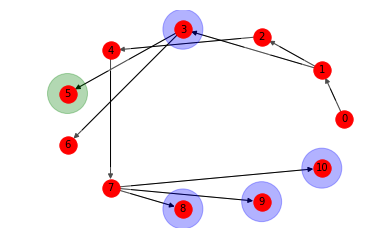

In [114]:
G = nx.DiGraph()
G.add_edges_from([(0,1), (1,2), (1,3), (2,4), (3,5), (3,6), (4,7), (7,8), (7,9), (7,10)])

TRUE = [5]
PRED = [3, 8, 9 ,10]

pos = nx.circular_layout(G)
val_map = {node: 'green' for node in TRUE}
for node in PRED:
    val_map[node] = 'blue' 
    
values = [val_map.get(node, 'white') for node in G.nodes()]

nx.draw_networkx_nodes(G,pos,node_size=1600, cmap=plt.get_cmap('jet'), 
                       node_color = values, alpha=0.3)
nx.draw_networkx_edges(G,pos,width=1,
                           alpha=0.3,edge_color='black')
nx.draw_networkx_labels(G, pos,font_size=10,
                            font_family='sans-serif')
nx.draw(G, pos)
plt.show()

In [117]:
def dag_metric(Y, _Y):
    path_cost = 0
    for to_true in Y:
        for to_pred in _Y:
            mutual_path_len = 0
            while mutual_path_len < min(len(to_pred), len(to_true)) and to_true[mutual_path_len] == to_pred[mutual_path_len]:
                mutual_path_len += 1

            side_error = len(to_pred[mutual_path_len - 1:])
            if side_error != 0:
                _path_cost = (mutual_path_len) / max(len(to_pred), len(to_true)) / len(to_pred[mutual_path_len - 1:])
            else:
                _path_cost = (mutual_path_len) / max(len(to_pred), len(to_true))
            if _path_cost > path_cost:
                path_cost = _path_cost
    return path_cost


bests = 0
for true in TRUE:
    best = 0
    for pred in PRED:
        To_true = list(nx.all_simple_paths(G, 0, true))
        To_pred = list(nx.all_simple_paths(G, 0, pred))
        _best = dag_metric(To_true, To_pred)
        if _best > best:
            best = _best
    bests += best

print(bests/len(TRUE))

0.75
